## Classification Trees in Python, From Start to Finish

In this lesson we will use scikit-learn and Cost Complexity Pruning to build this Classification Tree (below), which uses continuous and categorical data from the UCI Machine Learning Repository to predict whether or not a patient has heart disease:

Classification Trees are an exceptionally useful machine learning method when you need to to know how the decisions are being made. For example, if you have to justify the predictions to your boss, Classification Trees are a good method because each step in the decision making process is easy to understand.

## Import the modules that will do all the work

The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the classification tree.

In [1]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # to draw a confusion matrix

## Import the data

In [2]:
df = pd.read_csv("data/processed.cleveland.data",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


<div>
We see that instead of nice column names, we just have column numbers. Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:

age, 
sex,  
cp,     chest pain  
restbp,     resting blood pressure (in mm Hg)   
chol,    serum cholesterol in mg/dl 
fbs,     fasting blood sugar    
restecg,     resting electrocardiographic results   
thalach,     maximum heart rate achieved    
exang,   exercise induced angina    
oldpeak,    ST depression induced by exercise relative to rest  
slope,   the slope of the peak exercise ST segment.     
ca, number of major vessels (0-3) colored by fluoroscopy        
thal, this is short of thalium heart scan.  
hd, diagnosis of heart disease, the predicted attribute 
</div>

In [3]:
## change the column numbers to column names
df.columns = ['age', 
              'sex', 
              'cp', 
              'restbp', 
              'chol', 
              'fbs', 
              'restecg', 
              'thalach', 
              'exang', 
              'oldpeak', 
              'slope', 
              'ca', 
              'thal', 
              'hd']
## print the first 5 rows (including the column names)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We have replaced the column numbers with nice, easy to remember names. Now that we have the data in a dataframe called df, we are ready to identify and deal with Missing Data.

## Missing Data Part 1: Identifying Missing Data

Missing Data is simply a blank space, or a surrogate value like NA, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's age.

There are two main ways to deal with missing data:

1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for age, and age is not useful for classifying if people have heart disease or not, then it would be a shame to throw out all of someone's data just because we do not have their age.        
2. We can impute the values that are missing. In this context impute is just a fancy way of saying "we can make an educated guess about about what the value should be". Continuing our example where we are missing a value for age, instead of throwing out the entire row of data, we can fill the missing value with the average age or the median age, or use some other, more sophisticated approach, to guess at an appropriate value.

In [4]:
## dtypes tell us the "data type" for each column
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [5]:
## print out unique values in the column called 'ca'
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that ca contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in thal.

In [6]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, thal also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

## Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [8]:
## print the number of rows that contain missing values.
## loc[], short for "location", let's us specify which rows we want...
## and so we say we want any row with '?' in column 'ca'
## OR
## any row with '?' in column 'thal'
df.loc[ (df['ca']=='?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
len(df)

303

So 6 of the 303 rows, or 2%, contain missing values. Since 303 - 6 = 297, and 297 is plenty of data to build a classification tree, we will remove the rows with missing values, rather than try to impute their values.

In [14]:
## use loc[] to select all rows that do not contain missing values
## and save them in a new dataframe called "df_no_missing"
df_no_missing = df.loc[(df['ca'] != '?') 
                       & 
                       (df['thal'] != '?')]

Since df_no_missing has 6 fewer rows than the original df, it should have 297 rows.

In [15]:
len(df_no_missing)

297

In [16]:
df_no_missing['ca'].unique() , df_no_missing['thal'].unique()

(array(['0.0', '3.0', '2.0', '1.0'], dtype=object),
 array(['6.0', '3.0', '7.0'], dtype=object))

We have verified that df_no_missing does not contain any missing values. NOTE: ca and thal still have the object data type. That's OK. Now we are ready to format the data for making a Classification Tree.

# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a Classification Tree.

The first step is to split the data into two parts:

The columns of data that we will use to make classifications
The column of data that we want to predict.
We will use the conventional notation of X (capital X) to represent the columns of data that we will use to make classifications and y (lower case y) to represent the thing we want to predict. In this case, we want to predict hd (heart disease).

In [21]:
## Make a new copy of the columns used to make predictions
X = df_no_missing.drop('hd',axis=1).copy() # axis=1 means columns 0 means rows
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [31]:
## Make a new copy of the column of data we want to predict
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

# Format the Data Part 2: One-Hot Encoding

First, before we commit to converting cp with One-Hot Encoding, let's just see what happens when we convert cp without saving the results. This will make it easy to see how get_dummies() works.

In [23]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


In [25]:
X_encoded = pd.get_dummies(X,
    columns = ['cp'
               ,'restecg'
               ,'slope'
               ,'thal']
)
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Now we need to talk about the 3 categorical columns that only contain 0s and 1s: sex, fbs (fasting blood sugar), and exang (exercise induced angina). As we can see, One-Hot Encoding converts a column with more than 2 categories, like cp (chest pain) into multiple columns of 0s and 1s. Since sex, fbs, and exang only have 2 categories and only contain 0s and 1s to begin with, we do not have to do anything special to them, so we're done formatting the data for the Classification Tree.

Now, one last thing before we build a Classification Tree. y doesn't just contain 0s and 1s. Instead, it has 5 different levels of heart disease. 0 = no heart disease and 1-4 are various degrees of heart disease. We can see this with unique():

In [32]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [33]:
y_not_zero_index = y>0  # get the index for each non-zero value in y
y[y_not_zero_index] = 1   # set each non-zero value in y to 1
y.unique()              # verify that y only contains 0 and 1.

array([0, 1], dtype=int64)

# Build A Preliminary Classification Tree

At long last, the data are correctly formatted for making a Classification Tree. Now we simply split the data into training and testing sets and build the tree.

In [34]:
## split the data into training and testing sets using train_test_split sklearn module
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=.2,random_state=42)

#create a decision tree and fit to data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

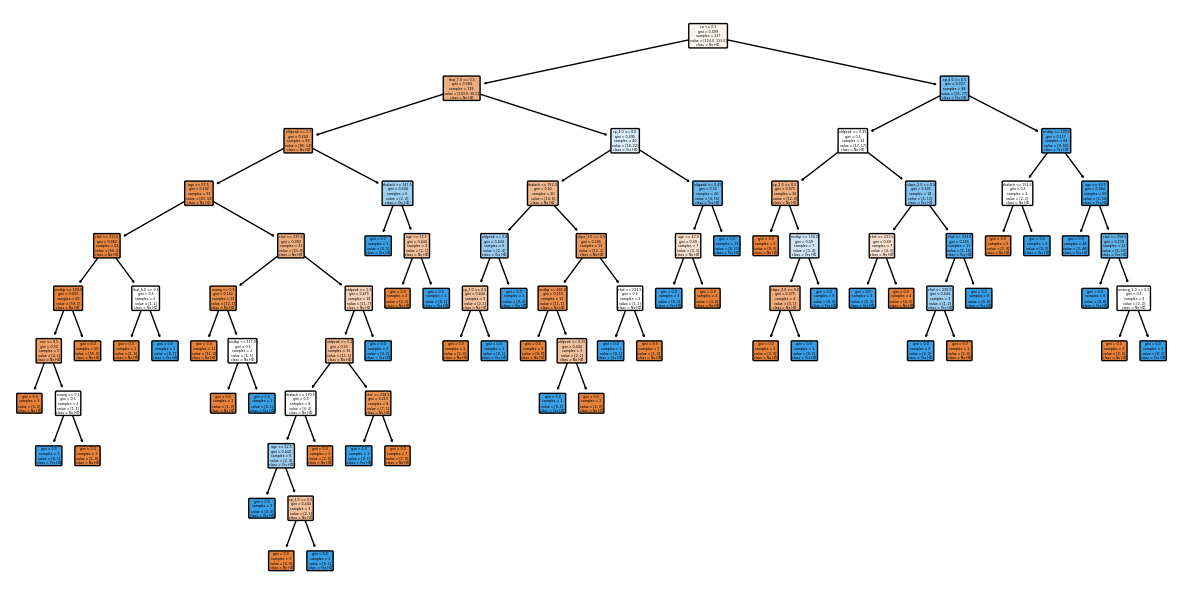

In [35]:
## NOTE: We can plot the tree and it is huge! 
# Clf_dt = classification decision Tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 